In [1]:
import pandas as pd
import numpy as np
import httpx
from datetime import datetime
import matplotlib.pyplot as plt

# Функции

## Функция для получения данных

In [2]:
async def fetch_data(url, params):
    async with httpx.AsyncClient() as client:
        try:
            response = await client.get(url, params=params, timeout=10.0)
            response.raise_for_status()
            result = response.json()
            return result

        except httpx.RequestError as e:
            return {"error": f"Request failed: {str(e)}"}
        except httpx.HTTPStatusError as e:
            return {"error": f"HTTP error: {str(e)}"}

## Функция для получения данных по свечам

In [3]:
async def get_bybit_kline(url,  symbol = "BTCUSDT", interval = "1", limit = 25):
    params = {
        "category": "spot",
        "symbol": symbol,
        "interval": interval,
        "limit": limit,
    }
    data = await fetch_data(url, params)

    return data

In [4]:
async def get_binance_kline(url,  symbol = "BTCUSDT", interval = "1m", limit = 25):
    params = {
        "symbol": symbol,
        "interval": interval,
        "timeZone": "+5",
        "limit": limit,
    }
    data = await fetch_data(url, params)

    return data

## Функция для приведения данных о свечах к единному формату

In [5]:
def format_kline_data(data):
    formatted_list = []
    list = data["list"]

    for elem in list:
        formatted_list.append(
            {
                "time": datetime.fromtimestamp(int(elem[0]) / 1000).strftime("%d-%m-%Y %H:%M:%S"),
                "open": float(elem[1]),
                "high": float(elem[2]),
                "low": float(elem[3]),
                "close": float(elem[4]),
                "volume": float(elem[5]),
                "turnover": float(elem[6]),
            }
        )

    return formatted_list

## Функция для приведения данных о свечах к единному формату для Binance

In [6]:
def format_kline_binance_data(data):
    formatted_list = []

    for elem in data:
        formatted_list.append({
            "time": datetime.fromtimestamp(int(elem[0]) / 1000).strftime("%d-%m-%Y %H:%M:%S"),
            "open": float(elem[1]),
            "high": float(elem[2]),
            "low": float(elem[3]),
            "close": float(elem[4]),
            "volume": float(elem[5]),
        })

    
    return formatted_list

## Функция для формирования датафрейма

In [7]:
def make_dataframe(data):
    df = 0
    dataframes = []

    start_time_object = datetime.strptime(data[0]["time"], "%d-%m-%Y %H:%M:%S")
    end_time_object = datetime.strptime(data[len(data) - 1]["time"], "%d-%m-%Y %H:%M:%S")

    start_time_ms = int(start_time_object.timestamp() * 1000)
    end_time_ms = int(end_time_object.timestamp() * 1000)

    for elem in data:
        elem["open"] = float(elem["open"])
        elem["close"] = float(elem["close"])
        elem["high"] = float(elem["high"])
        elem["low"] = float(elem["low"])
        elem["volume"] = float(elem["volume"])
        dataframes.append(pd.DataFrame(elem, index=[0]))

    initial_df = pd.concat(dataframes, ignore_index=True)

    if start_time_ms > end_time_ms:
        df = initial_df.iloc[::-1].reset_index(drop=True)
    else:
        df = initial_df

    df["time"] = pd.to_datetime(df["time"])

    return df

## Функция для расчета осцилятора Чайкина

In [8]:
def chaikin_osc(df):
        # 1. Рассчитать Money Flow Multiplier
    df["mf_multiplier"] = ((df["close"] - df["low"]) - (df["high"] - df["close"])) / (df["high"] - df["low"])

    # 2. Рассчитать Money Flow Volume
    df["mf_volume"] = df["mf_multiplier"] * df["volume"]

    # 3. Рассчитать ADL
    df["adl"] = df["mf_volume"].cumsum()

    # 4. Рассчитать EMA для short и long периодов
    short_period = 3
    long_period = 10

    df["ema_short"] = df["adl"].ewm(span=short_period, adjust=False).mean()
    df["ema_long"] = df["adl"].ewm(span=long_period, adjust=False).mean()

    # 5. Рассчитать Chaikin Oscillator
    df["chaikin_osc"] = df["ema_short"] - df["ema_long"]

    return df

## Функция для расчета RSI

In [9]:
def rsi(df, period):
    df["delta"] = df["close"].diff()  # Разница между текущей и предыдущей ценой закрытия

    df["gain"] = df["delta"].where(df["delta"] > 0, 0)  # Приросты (положительные изменения)
    df["loss"] = -df["delta"].where(df["delta"] < 0, 0)  # Потери (отрицательные изменения)

    # Скользящее среднее приростов и потерь
    df["avg_gain"] = df["gain"].rolling(window=period, min_periods=1).mean()
    df["avg_loss"] = df["loss"].rolling(window=period, min_periods=1).mean()

    # Отношение приростов к потерям
    df["rs"] = df["avg_gain"] / df["avg_loss"]
    df["RSI"] = 100 - (100 / (1 + df["rs"]))  # Формула RSI

    return df

## Функция для расчета SMA

In [10]:
def sma(df, period):
    df["SMA"] = df["close"].rolling(window=period).mean()

    return df

## Функция для расчета MACD

In [11]:
def macd(df, short_window=12, long_window=26, signal_window=9):
    df["EMA_short"] = df["close"].ewm(span=short_window, adjust=False).mean()
    df["EMA_long"] = df["close"].ewm(span=long_window, adjust=False).mean()

    df["MACD"] = df["EMA_short"] - df["EMA_long"]
    df["Signal_Line"] = df["MACD"].ewm(span=signal_window, adjust=False).mean()
    df["Histogram"] = df["MACD"] - df["Signal_Line"]

    return df

# Bybit

## Получаем данные по свечам

In [12]:
url = "https://api.bybit.com/v5/market/kline"

kline_data = await get_bybit_kline(url, symbol="BTCUSDT", interval=1, limit=1000)
klines = format_kline_data(kline_data["result"])

klines_df_0 = make_dataframe(klines)

klines_df_1 = chaikin_osc(klines_df_0)

klines_df_2 = rsi(klines_df_1, period=14)

# Настройка отображения
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.width', 0)          # Не ограничивать ширину строки
pd.set_option('display.expand_frame_repr', False)


print(klines_df_2[["time", "open", "close", "volume", "chaikin_osc", "RSI"]])

                   time      open     close     volume  chaikin_osc        RSI
0   2025-04-01 00:44:00  98737.23  98690.00  15.965044     0.000000        NaN
1   2025-04-01 00:45:00  98690.00  98642.25  17.298225     0.136026   0.000000
2   2025-04-01 00:46:00  98642.25  98670.08  12.009206     0.315089  36.821911
3   2025-04-01 00:47:00  98670.08  98590.38  12.709004    -1.853348  17.922463
4   2025-04-01 00:48:00  98590.38  98647.57  12.856519     1.517519  40.015061
..                  ...       ...       ...        ...          ...        ...
995 2025-04-01 17:19:00  97824.73  97858.34   4.432772    -0.940019  38.989436
996 2025-04-01 17:20:00  97858.34  97900.91   9.111874     2.643978  55.656778
997 2025-04-01 17:21:00  97900.91  97891.31   4.540218     2.428189  56.148619
998 2025-04-01 17:22:00  97891.31  97932.91   6.251005     2.953354  62.171777
999 2025-04-01 17:23:00  97932.91  97946.34   2.284908     3.626725  66.281848

[1000 rows x 6 columns]


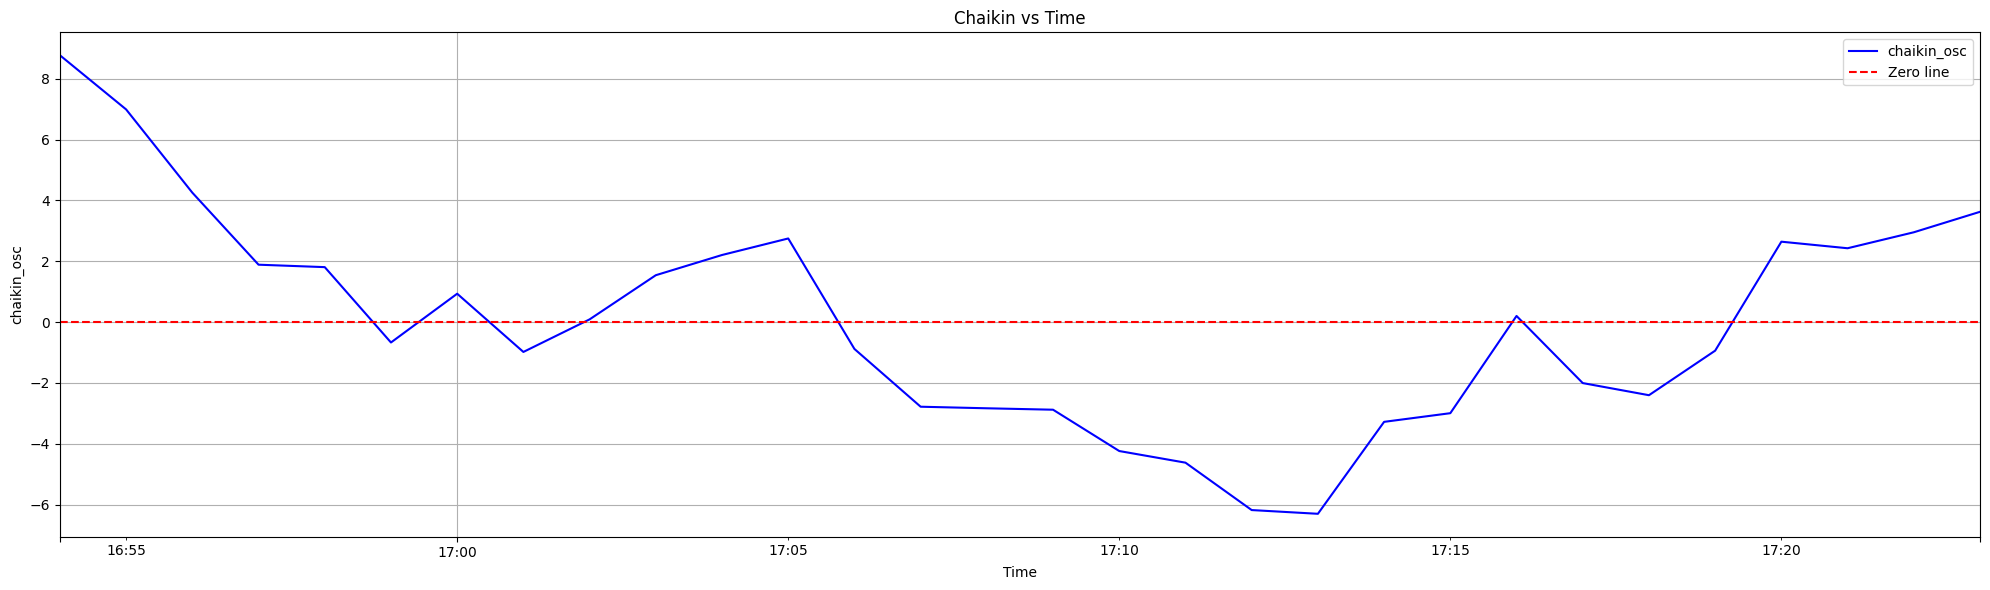

In [13]:
klines_df_2[-30:].plot(
    x='time', 
    y='chaikin_osc', 
    figsize=(20, 6),  # Размер графика
    title='Chaikin vs Time',  # Заголовок
    color='blue',  # Цвет линии
    linewidth=1.5,  # Толщина линии
    grid=True  # Включить сетку
);

# Добавление уровней 0
plt.axhline(0, color='red', linestyle='--', label='Zero line')


plt.legend()
plt.xlabel('Time')
plt.ylabel('chaikin_osc')
plt.tight_layout()
plt.show()

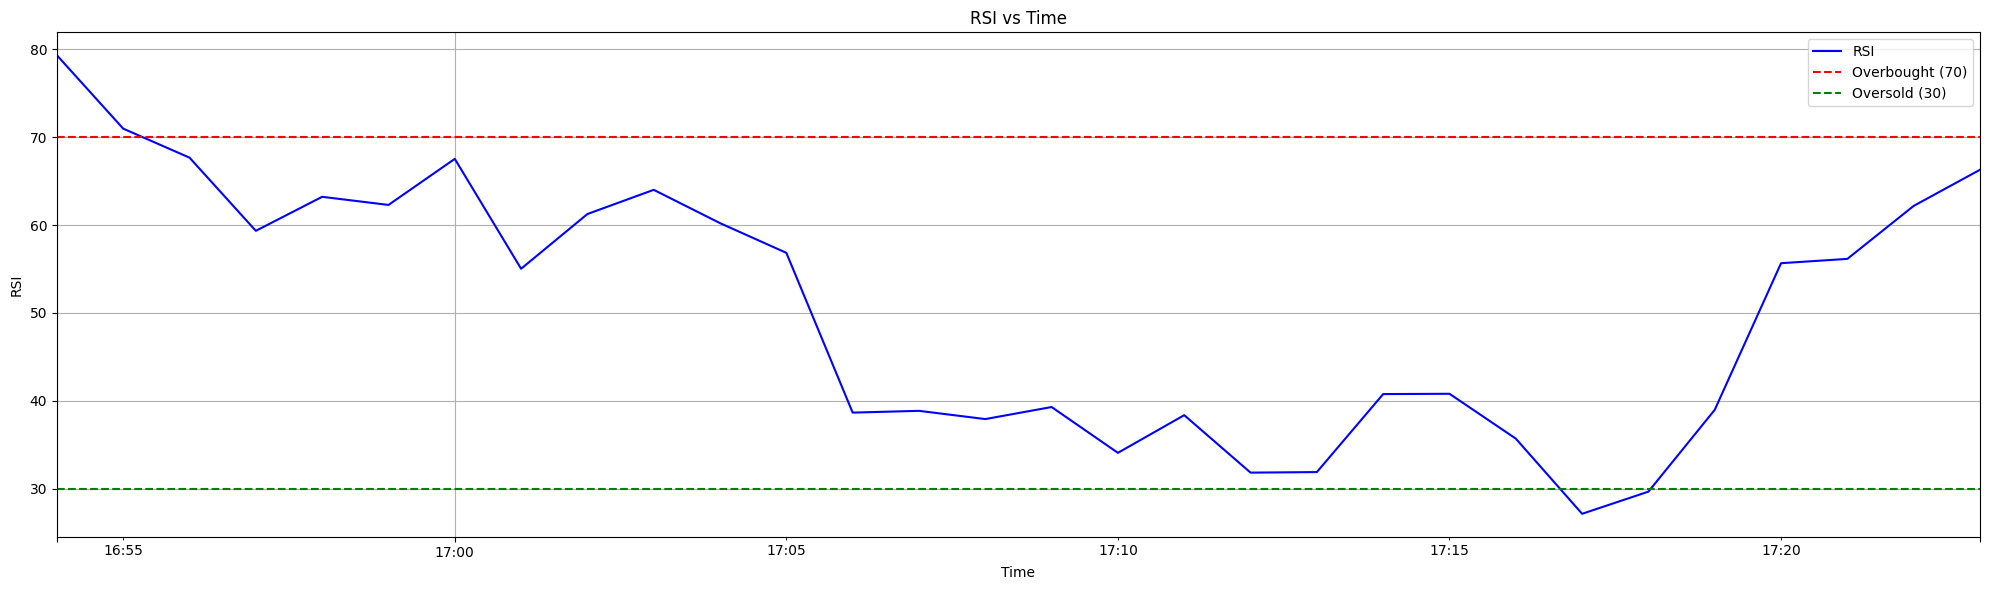

In [14]:
klines_df_2[-30:].plot(
    x='time', 
    y='RSI', 
    figsize=(20, 6),  # Размер графика
    title='RSI vs Time',  # Заголовок
    color='blue',  # Цвет линии
    linewidth=1.5,  # Толщина линии
    grid=True  # Включить сетку
);

# Добавление уровней 70 и 30
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')

plt.legend()
plt.xlabel('Time')
plt.ylabel('RSI')
plt.tight_layout()
plt.show()

# Binance

In [15]:
url = "https://api.binance.com/api/v3/klines"

kline_data = await get_binance_kline(url, symbol="BTCUSDT", interval="1m", limit=1000)
klines = format_kline_binance_data(kline_data)

klines_df_0 = make_dataframe(klines)

klines_df_1 = chaikin_osc(klines_df_0)

klines_df_2 = rsi(klines_df_1, period=14)

klines_df_3 = sma(klines_df_2, period=9)

klines_df_4 = macd(klines_df_3, short_window=12, long_window=26, signal_window=9)

# Настройка отображения
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.width', 0)          # Не ограничивать ширину строки
pd.set_option('display.expand_frame_repr', False)


print(klines_df_4[["time", "open", "close", "volume", "chaikin_osc", "RSI", "SMA", "MACD", "Signal_Line", "Histogram"]])

                   time      open     close    volume  chaikin_osc        RSI           SMA       MACD  Signal_Line  Histogram
0   2025-04-01 00:44:00  98738.48  98698.23   9.21729     0.000000        NaN           NaN   0.000000     0.000000   0.000000
1   2025-04-01 00:45:00  98697.39  98638.53  17.31908    -1.022869   0.000000           NaN  -4.762393    -0.952479  -3.809915
2   2025-04-01 00:46:00  98638.53  98659.05   4.57579    -1.619185  25.579656           NaN  -6.802418    -2.122466  -4.679951
3   2025-04-01 00:47:00  98659.05  98580.15  11.46513    -4.144081  12.895928           NaN -14.617224    -4.621418  -9.995806
4   2025-04-01 00:48:00  98580.15  98634.31   9.10575    -2.351140  35.015004           NaN -16.252901    -6.947715  -9.305187
..                  ...       ...       ...       ...          ...        ...           ...        ...          ...        ...
995 2025-04-01 17:19:00  97810.98  97841.16   3.46476    -5.768994  36.802500  97814.130000 -10.668377    -7.00

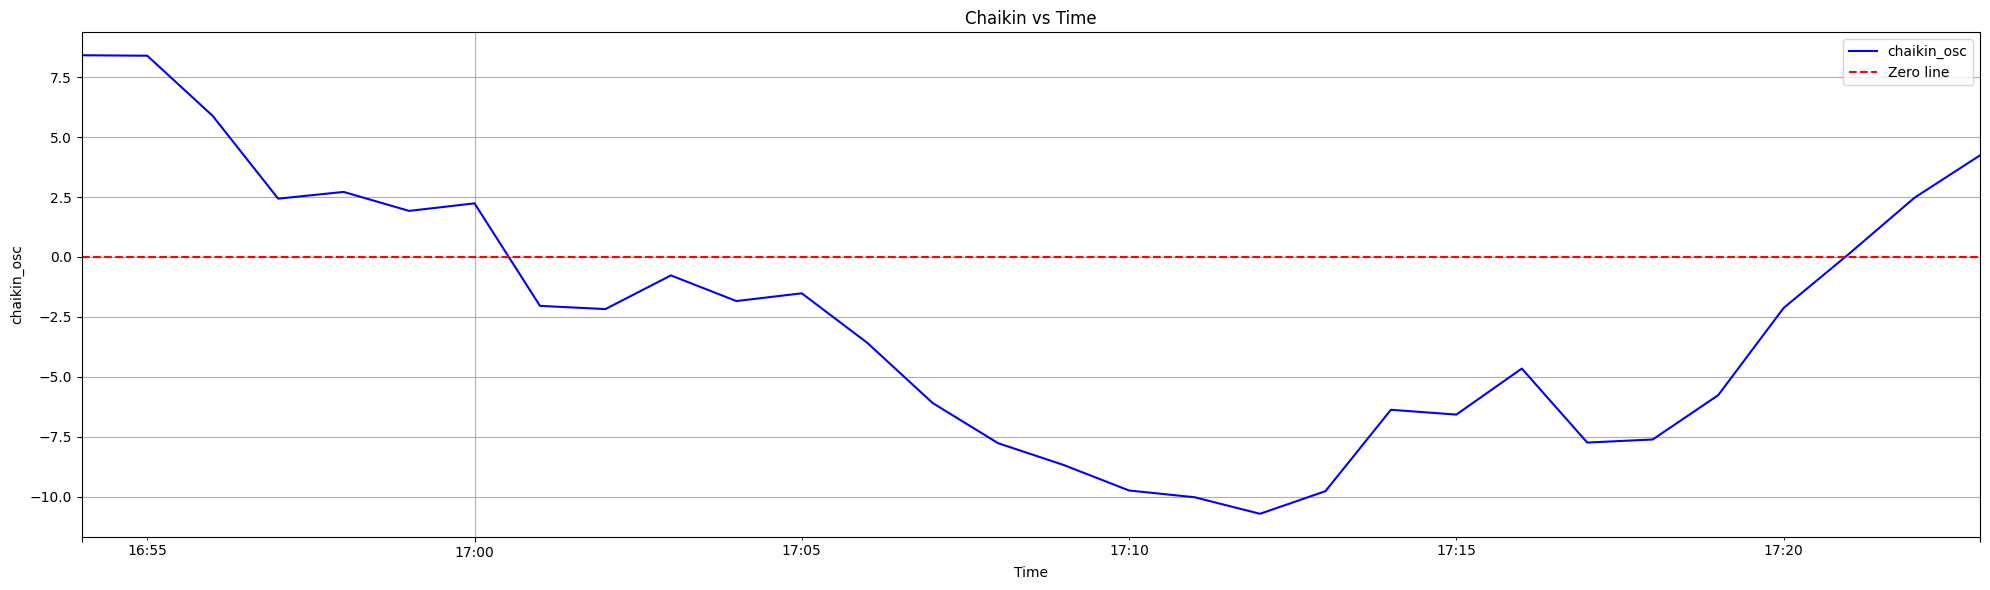

In [16]:
klines_df_2[-30:].plot(
    x='time', 
    y='chaikin_osc', 
    figsize=(20, 6),  # Размер графика
    title='Chaikin vs Time',  # Заголовок
    color='blue',  # Цвет линии
    linewidth=1.5,  # Толщина линии
    grid=True  # Включить сетку
);

# Добавление уровней 0
plt.axhline(0, color='red', linestyle='--', label='Zero line')


plt.legend()
plt.xlabel('Time')
plt.ylabel('chaikin_osc')
plt.tight_layout()
plt.show()

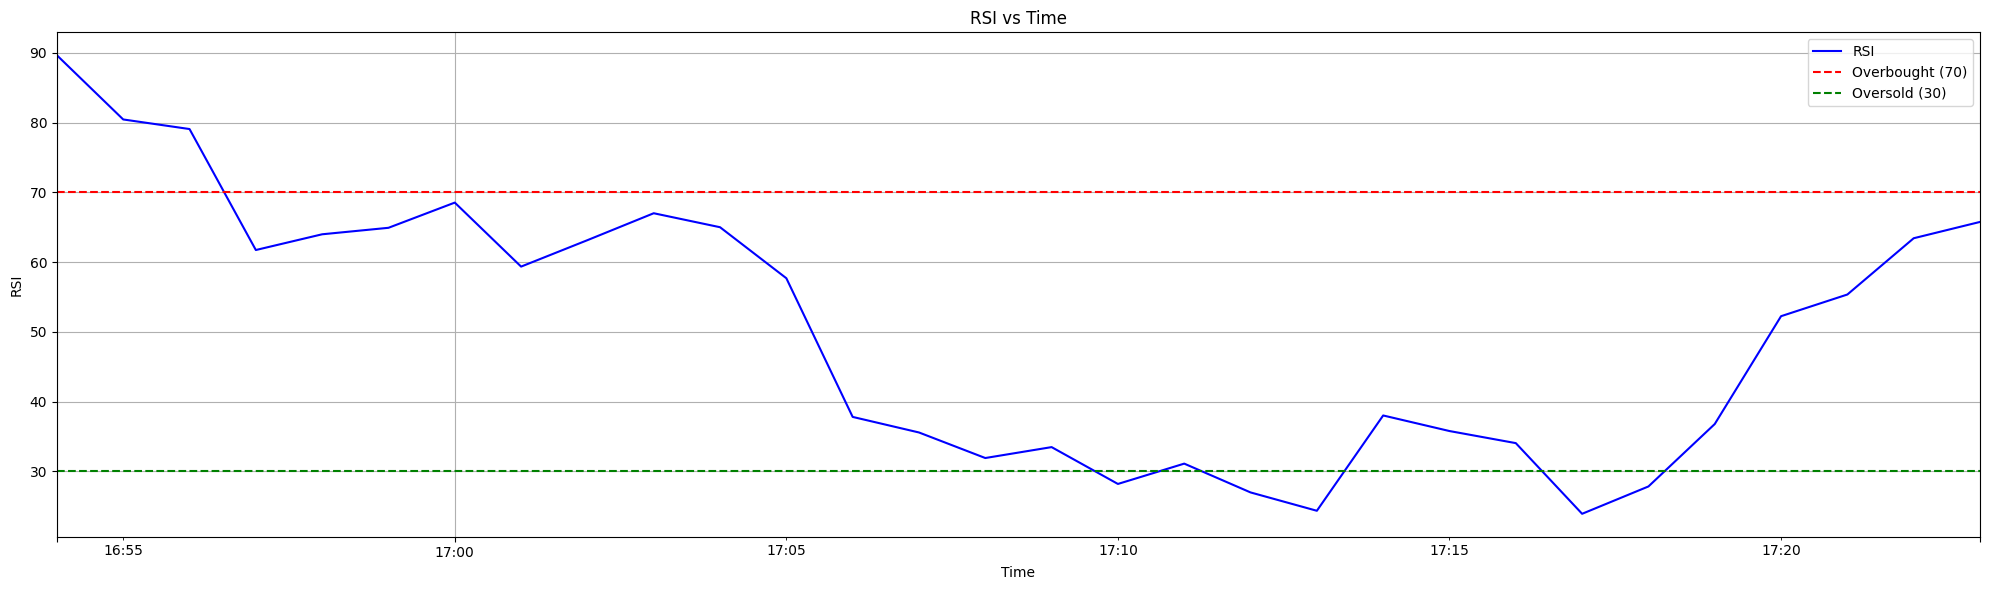

In [17]:
klines_df_2[-30:].plot(
    x='time', 
    y='RSI', 
    figsize=(20, 6),  # Размер графика
    title='RSI vs Time',  # Заголовок
    color='blue',  # Цвет линии
    linewidth=1.5,  # Толщина линии
    grid=True  # Включить сетку
);

# Добавление уровней 70 и 30
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')

plt.legend()
plt.xlabel('Time')
plt.ylabel('RSI')
plt.tight_layout()
plt.show()